In [10]:
#INF2178 assignment 4 (Winter2024)
#Michelle Lee (student no 1001448169)

#import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
%pip install bioinfokit
from bioinfokit.analys import stat

#load data
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/INF2178_A4_data.csv')

#print first few rows to see content in dataset
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Unnamed: 0 Subject ID         MRI ID        Group  Visit  MR Delay M/F  \
0           0  OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M   
1           1  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M   
2           2  OAS2_0002  OAS2_0002_MR1     Demented      1         0   M   
3           3  OAS2_0002  OAS2_0002_MR2     Demented      2       560   M   
4           5  OAS2_0004  OAS2_0004_MR1  Nondemented      1         0   F   

  Hand  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF  
0    R   87    14  2.0  27.0  0.0  1987  0.696  0.883  
1    R   88    14  2.0  30.0  0.0  2004  0.681  0.876  
2    R   75    12  NaN  23.0  0.5  1678  0.736  1.046  
3    R   76    12  NaN  28.0  0.5  1738  0.713  1.010  
4    R   88    18  3.0  28.0  0.0  1215  0.710  1.444  


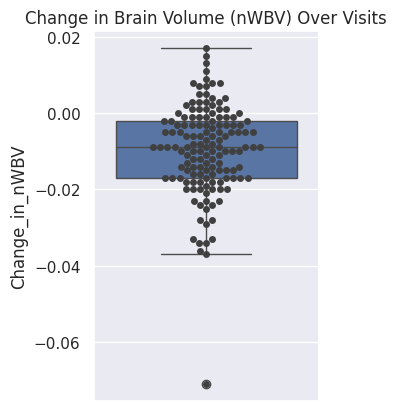

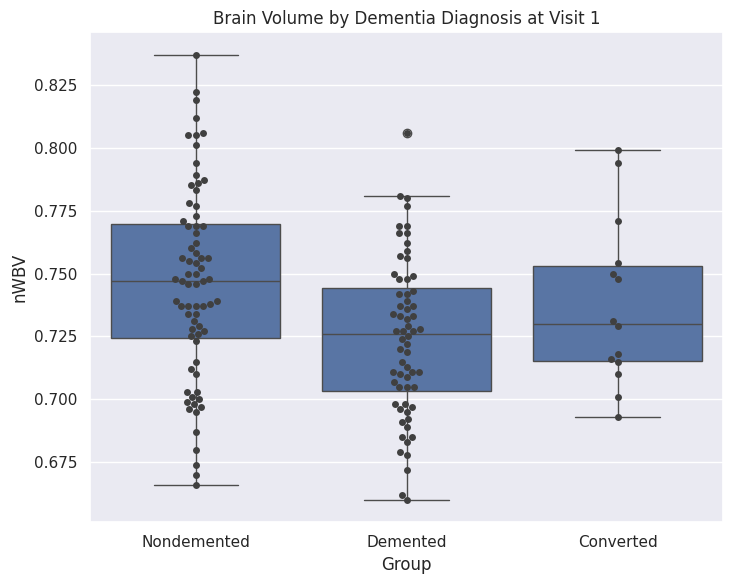

In [11]:
#eda - boxplot
#within subjects boxplot - change in Brain Volume (nWBV) vs Visits

#import library
import matplotlib.pyplot as plt
import seaborn as sns

#subset + create variables for difference in nWBV from Visit 1 to Visit 2
df_within_subjects = df.pivot(index='Subject ID', columns='Visit', values='nWBV').dropna()
df_within_subjects['Change_in_nWBV'] = df_within_subjects[2] - df_within_subjects[1]
df_within_subjects = df_within_subjects.reset_index()
#aesthetics - within subject
plt.subplot(1, 2, 1)
sns.boxplot(y='Change_in_nWBV', data=df_within_subjects)
sns.swarmplot(y='Change_in_nWBV', data=df_within_subjects, color=".25")
plt.title('Change in Brain Volume (nWBV) Over Visits')

#between-subjects boxplot - brain volume vs dementia diagnosis
#subset for just visit 1
df_between_subjects = df[df['Visit'] == 1]
plt.figure(figsize=(14, 6))
#aesthetics - btwn subjects
plt.subplot(1, 2, 2)
sns.boxplot(x='Group', y='nWBV', data=df_between_subjects)
sns.swarmplot(x='Group', y='nWBV', data=df_between_subjects, color=".25")
plt.title('Brain Volume by Dementia Diagnosis at Visit 1')

plt.tight_layout()
plt.show()

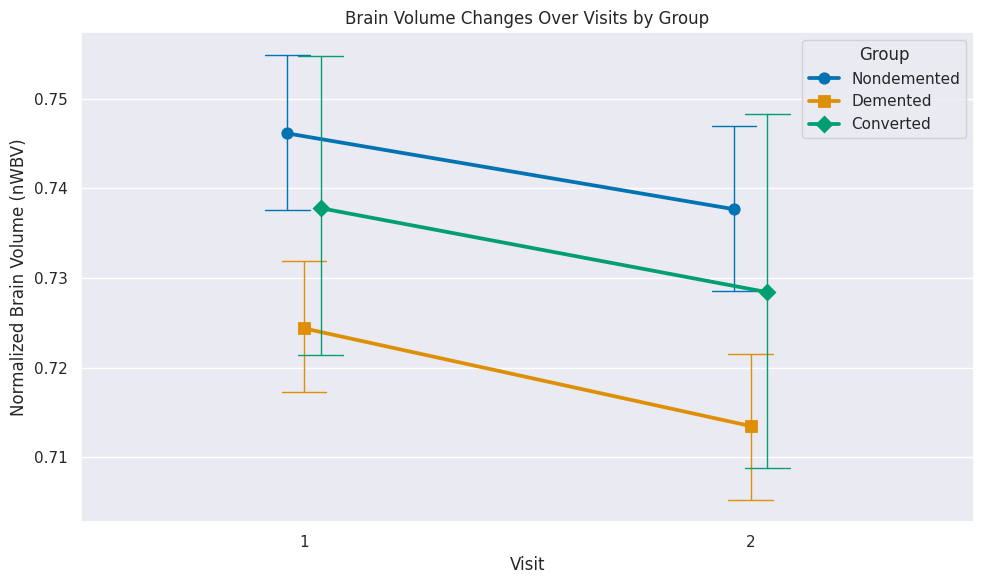

In [12]:
#eda - interaction plot
#set seaborn
sns.set()

#plot interaction plot for viist, nWBV and group variables
plt.figure(figsize=(10, 6))
sns.pointplot(data=df, x='Visit', y='nWBV', hue='Group', dodge=True, #adjust hue aesthetics so no overlapping lines
              markers=['o', 's', 'D'], #marker symbols for groups
              capsize=.1, err_kws={'linewidth':1}, palette='colorblind') #set error bar widths with err_kws

plt.xlabel('Visit')
plt.ylabel('Normalized Brain Volume (nWBV)')
plt.title('Brain Volume Changes Over Visits by Group')
plt.legend(title='Group')
plt.tight_layout()
plt.show()

In [13]:
#power analysis - find sample size

#import libraries etc
%pip install statsmodels
from statsmodels.stats.power import TTestIndPower

#factors for power analysis (given in instructions)
effect_size = 0.7
alpha = 0.05
power = 0.91

#make analysis variable for t-test
power_analysis = TTestIndPower()

#calclate he sample size
sample_size = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=1, alternative='two-sided')
print('Sample size needed per group: {:.3f}'.format(sample_size))

#calculate the power directly for given factors and using sample_size
actual_power = power_analysis.solve_power(effect_size=0.5, nobs1=sample_size, alpha=alpha, power=None)
print('Power given sample size {:.3f} and effect size 0.5: {:.3f}'.format(sample_size, actual_power))


Sample size needed per group: 45.451
Power given sample size 45.451 and effect size 0.5: 0.655


<Figure size 1000x600 with 0 Axes>

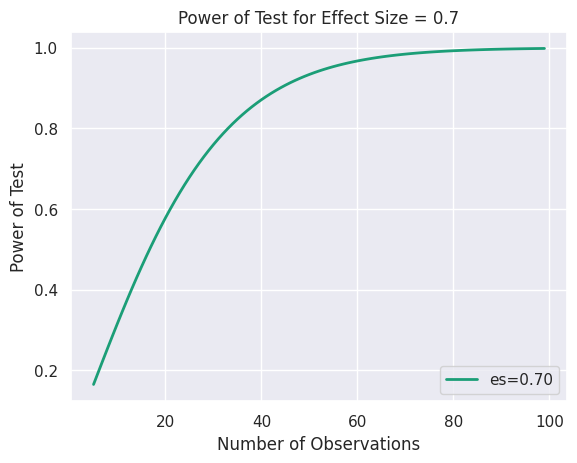

In [18]:
#power analysis - power curves visuals
#install librarires
%pip install statsmodels
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower

#define sample sizes
effect_sizes = np.array([0.7])
sample_sizes = np.array(range(5, 100))  #based on in-class example

#power analysis object for t-test
power_analysis = TTestIndPower()

#plot power curve
plt.figure(figsize=(10, 6))
power_analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.title('Power of Test for Effect Size = 0.7')
plt.xlabel('Number of Observations')
plt.ylabel('Power of Test')

plt.show()



In [15]:
#anova computing
#import librarires
import pandas as pd
!pip install pingouin
import pingouin as pg

#clean and drop Nan values
df = df.dropna(subset=['nWBV', 'Visit', 'Group', 'Subject ID'])

#two-way mixed ANOVA
aov = pg.mixed_anova(dv='nWBV', within='Visit', between='Group', subject='Subject ID', data=df)

#print ANOVA table
pg.print_table(aov)



ANOVA SUMMARY

Source          SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------  -----  -----  -----  -----  ------  -------  -----  -------
Group        0.034      2    141  0.017   6.712    0.002  0.087  nan
Visit        0.007      1    141  0.007  94.251    0.000  0.401    1.000
Interaction  0.000      2    141  0.000   1.534    0.219  0.021  nan



In [16]:
#assumption check: normality of residual - shapiro wilk
#import library
from scipy.stats import shapiro

#subset group, visit, nWBV variables from df
df['predicted_nWBV'] = df.groupby(['Group', 'Visit'])['nWBV'].transform('mean')
#define residuals var
df['residuals'] = df['nWBV'] - df['predicted_nWBV']

#shapiro-wilk test
for group in df['Group'].unique():
    for visit in df['Visit'].unique():
        group_visit_data = df[(df['Group'] == group) & (df['Visit'] == visit)]
        shapiro_test = shapiro(group_visit_data['residuals'].dropna())
        print(f"Group: {group}, Visit: {visit}, Shapiro-Wilk test statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}")

Group: Nondemented, Visit: 1, Shapiro-Wilk test statistic: 0.9887233376502991, p-value: 0.7719990015029907
Group: Nondemented, Visit: 2, Shapiro-Wilk test statistic: 0.9839560985565186, p-value: 0.5108829736709595
Group: Demented, Visit: 1, Shapiro-Wilk test statistic: 0.9920073747634888, p-value: 0.9546263217926025
Group: Demented, Visit: 2, Shapiro-Wilk test statistic: 0.9794751405715942, p-value: 0.38469114899635315
Group: Converted, Visit: 1, Shapiro-Wilk test statistic: 0.9335074424743652, p-value: 0.341467946767807
Group: Converted, Visit: 2, Shapiro-Wilk test statistic: 0.940329372882843, p-value: 0.5023510456085205


In [17]:
#assumption check: homogeneity of variances - levenes
#import library
from scipy.stats import levene

#levene's test
stat, p_value = levene(*[group['nWBV'].dropna() for name, group in df.groupby(['Group', 'Visit'])])

print(f"Levene's test statistic: {stat}, p-value: {p_value}")

Levene's test statistic: 0.53054552892683, p-value: 0.7530986768710662
